<div style="background:#FFFFAA">
<img src="logo.jpg", width=150, ALIGN="left", border=20>
<h1>Sample Starting Kit </h1>
    <span style="color:red"> <h1> Keep all code below **yellow** text blocks, </h1> </span>
    <span style="color:red"> <h1> but check that it works (you can ADD not remove). </h1> </span>
    <span style="color:red"> <h1> Customize Section (1) and modify the explanations.</h1> </span>

<br>This code was tested with <br>
Python 3.8.5 |Anaconda custom (64-bit)| (default, Sep  4 2020, 02:22:02) (https://anaconda.org/)<br>
<i> Adapted for original code of Balázs Kégl</i> <br>
</center>
<p>
ALL INFORMATION, SOFTWARE, DOCUMENTATION, AND DATA ARE PROVIDED "AS-IS". The CHALEARN, AND/OR OTHER ORGANIZERS OR CODE AUTHORS DISCLAIM ANY EXPRESSED OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR ANY PARTICULAR PURPOSE, AND THE WARRANTY OF NON-INFRIGEMENT OF ANY THIRD PARTY'S INTELLECTUAL PROPERTY RIGHTS. IN NO EVENT SHALL AUTHORS AND ORGANIZERS BE LIABLE FOR ANY SPECIAL, 
INDIRECT OR CONSEQUENTIAL DAMAGES OR ANY DAMAGES WHATSOEVER ARISING OUT OF OR IN CONNECTION WITH THE USE OR PERFORMANCE OF SOFTWARE, DOCUMENTS, MATERIALS, PUBLICATIONS, OR INFORMATION MADE AVAILABLE FOR THE CHALLENGE. 
</div>

<div style="background:#FFFFAA">
    <h2>Introduction </h2>
    <p>
    <span style="color:red"> Here write here a short description of your problem. </span>
     <br>

In this challenge you are going to try to classify whether a picture of a lung is that of a pneumonia patient. The data in this notebook is taken from the activation layer of neural networks that where trained on the originial image data. You can try using this as an input for different ML techniques such as Support Vector Machines, Random Forest Classifiers or Neural Networks.
        
 <br>
    <span style="color:red"> Keep the next block. </span>
</div>

In [1]:
model_dir = 'sample_code_submission/'                        # Change the model to a better one once you have one!
#model_dir = '../FILES/pretty_good_sample_code_submission/'
result_dir = 'sample_result_submission/' 
problem_dir = 'ingestion_program/'  
score_dir = 'scoring_program/'

In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

import sklearn.model_selection

import matplotlib.pyplot as plt# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

import sklearn.model_selection

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.patches
from matplotlib import image


import time
import os
import copy
from pathlib import Path
import shutil
import sys

import random
# from PIL import Image, ImageDraw, ImageFont
import PIL
from sklearn.model_selection import train_test_split
import cv2
import scipy.ndimage.interpolation
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.patches
from matplotlib import image


import time
import os
import copy
from pathlib import Path
import shutil
import sys

import random
# from PIL import Image, ImageDraw, ImageFont
import PIL
from sklearn.model_selection import train_test_split
import cv2
import scipy.ndimage.interpolation

<div style="background:#FFFFAA">
    <h1> Step 1: Exploratory data analysis </h1>
<p>
We provide sample_data with the starting kit, but to prepare your submission, you must fetch the public_data from the challenge website and point to it.
    <br>
    <span style="color:red"> Just change the data name in the block below. In the rest of the section, replace the sample plots by anything you want. </span>
</div>

In [3]:
import os
sample_imgs_dir = 'sample_images'


image_dir = Path('../image_data')

#sample_imgs_dir = 'image_data'

sample_imgs_names = os.listdir(sample_imgs_dir)

First we show you the original data, that is radiology images from healthy and sick individuals. This data was used to create the tabular data that your classification will run on.

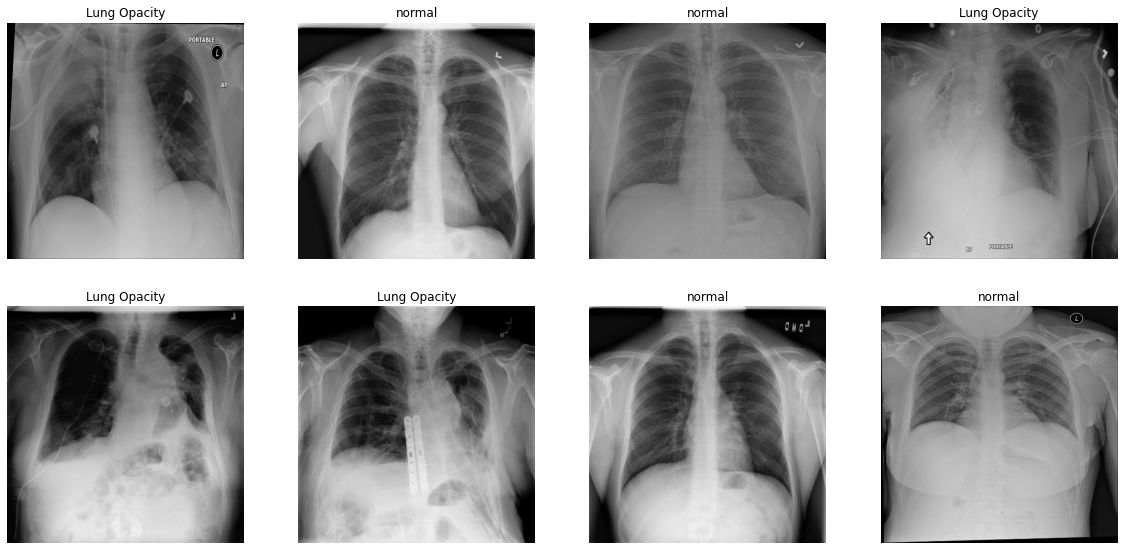

In [4]:
def show_images(images, rows=4, cols=4, figsize=(20, 20),title=None):
    figure = plt.figure(figsize=figsize)
    for idx, img in enumerate(images):
        label = img.split('_')[1].split('.')[0] 
        ax = plt.subplot(rows, cols, idx + 1)
        img = image.imread(os.path.join(sample_imgs_dir, img))
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
        if idx > 6:
            break
    if title is not None:
        plt.title(title)
show_images(sample_imgs_names)

In [5]:
metadata = pd.read_csv('image_meta_data/image_bbox_full.csv')
#display(metadata.describe())
#display(metadata.sample(5))
#print(metadata.shape)

In [6]:
class_names=['No opacity','Opacity']

In [7]:
#https://github.com/utkuozbulak/pytorch-custom-dataset-examples/blob/master/README.md#incorporating-pandas
    
class ImgDataset(torch.utils.data.Dataset):
    def __init__(self,df,img_dir):
        self.transform = transforms.Compose([
        transforms.Resize(128),
        transforms.ToTensor(),
        ])
        self.df=df
        self.img_dir=img_dir
        self.image_arr = np.asarray(self.df.iloc[:, 0]+'.jpeg')
        self.label_arr = np.asarray(self.df.iloc[:, 5])
        self.data_len = len(self.df.index)

    def __getitem__(self, index):
        single_image_name = self.image_arr[index]
        img_as_img = PIL.Image.open(self.img_dir.joinpath(single_image_name))
        img_transformed = self.transform(img_as_img)
        single_image_label = self.label_arr[index]
        return img_transformed, single_image_label

    def __len__(self):
        return self.data_len

In [8]:
def filter_data(df):
    filtered_df = df[df['class'] != 'No Lung Opacity / Not Normal']
    filtered_df = filtered_df.drop_duplicates(subset='patientId')
    return filtered_df

filtered_data = filter_data(metadata)
display(filtered_data['class'].value_counts())

Normal          8851
Lung Opacity    6012
Name: class, dtype: int64

In [9]:
metadata[metadata['Target']==1].sample(5)

,patientId,x,y,width,height,Target,class,boxes,path
5185,3c319790-02cd-44d7-bb91-8e758463ac82,618.0,149.0,324.0,659.0,1,Lung Opacity,1,../input/stage_2_train_images/3c319790-02cd-44...
19396,ac87627c-76ef-4704-b965-6e2badb21d5e,139.0,109.0,299.0,493.0,1,Lung Opacity,2,../input/stage_2_train_images/ac87627c-76ef-47...
2759,22f2d3ec-f7ea-4778-850d-bb111590202f,213.0,321.0,169.0,137.0,1,Lung Opacity,1,../input/stage_2_train_images/22f2d3ec-f7ea-47...
4341,36bd8ee6-cfb2-48ae-a57d-dcea7ba8deec,329.0,417.0,130.0,130.0,1,Lung Opacity,1,../input/stage_2_train_images/36bd8ee6-cfb2-48...
16745,980f7412-072b-4cc4-846d-99fc5607d70c,124.0,521.0,306.0,379.0,1,Lung Opacity,1,../input/stage_2_train_images/980f7412-072b-4c...


<div style="background:#FFFFAA">
<h1>Step 2: Building a predictive model</h1>
</div>

<div style="background:#FFFFAA">
    <h2>Loading data with DataManager</h2>
    <p>
We reload the data with the AutoML DataManager class because this is more convenient:
   <br>     <span style="color:red"> Keep this, it illustrates how data in AutoML formal are loaded by the ingestion program </span>
</div>

In [10]:
class ImgDataset(torch.utils.data.Dataset):
    def __init__(self,df,img_dir):
        """
        Args:
            csv_path (string): path to csv file
            img_path (string): path to the folder where images are
            transform: pytorch transforms for transforms and tensor conversion
        """
        # Transforms
        self.transform = transforms.Compose([

        transforms.Resize(128),
        transforms.ToTensor(),
        ])
        # First column contains the image paths
        self.df=df
        self.img_dir=img_dir
        self.image_arr = np.asarray(self.df.iloc[:, 0]+'.jpeg')
        self.label_arr = np.asarray(self.df.iloc[:, 5])

        self.data_len = len(self.df.index)

    def __getitem__(self, index):
        # Get image name from the pandas df
        single_image_name = self.image_arr[index]
        img_as_img = PIL.Image.open(self.img_dir.joinpath(single_image_name))
        img_transformed = self.transform(img_as_img)
        
        single_image_label = self.label_arr[index]

        return img_transformed, single_image_label

    def __len__(self):
        return self.data_len


In [11]:
def filter_data(df):
  filtered_df = df[df['class'] != 'No Lung Opacity / Not Normal']
  filtered_df = filtered_df.drop_duplicates(subset='patientId')
  return filtered_df

filtered_data = filter_data(metadata)
display(filtered_data['class'].value_counts())


Normal          8851
Lung Opacity    6012
Name: class, dtype: int64

In [12]:
train_df, valid_df = sklearn.model_selection.train_test_split(
      filtered_data, test_size=0.1, 
      random_state=2021, shuffle=True, 
      stratify=filtered_data['class'],
)

train_ds=ImgDataset(train_df,image_dir)
valid_ds=ImgDataset(valid_df,image_dir)


In [16]:
batch_size = 64
dataloaders = {'val':torch.utils.data.DataLoader(valid_ds, batch_size=batch_size,
                                             shuffle=False, 
                                            #  num_workers=4,
                                             )
              ,
              'train':torch.utils.data.DataLoader(train_ds, batch_size=batch_size,
                                             shuffle=True, 
                                            #  num_workers=4,
                                             )
               }

dataset_sizes = {'val': len(valid_ds),
                 'train':len(train_ds)
                 }
#class_names=metadata['class'].unique() 
# class_names=['No opacity','Opacity']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [17]:
feature_ds = ImgDataset(filtered_data, image_dir)

14863


In [18]:
feature_dataloader = torch.utils.data.DataLoader(feature_ds, batch_size=64,shuffle=False)

In [ ]:
# weird ass stuff I hardly understand

In [ ]:
def format_image_for_display(img_tensor):
    return img_tensor.numpy().transpose((1, 2, 0))

In [ ]:
def show_images(images, labels, class_names=class_names, rows=4, cols=4, figsize=(16, 16),title=None):
    """Imshow for Tensor."""

    figure = plt.figure(figsize=figsize)
    for idx, img in enumerate(images):
        ax = plt.subplot(rows, cols, idx + 1)
        plt.imshow(img.numpy().transpose((1, 2, 0)))
        plt.title(class_names[labels[idx]])
        plt.axis('off')

    if title is not None:
        plt.title(title)

<div style="background:#FFFFAA">
    <h2>Training a predictive model</h2>
    <p>
We provide an example of predictive model (for classification or regression) in the `sample_code_submission/` directory. It is a quite stupid model: it makes constant predictions. Replace it with your own model.
    </div>

In [ ]:
from data_io import write
from model import model
# Uncomment the next line to show the code of the model
#??model 

<div style="background:#FFFFAA">
an instance of the model (run the constructor) and attempt to reload a previously saved version from `sample_code_submission/`:
    
</div>

In [ ]:
#M = model()
#trained_model_name = model_dir + data_name
# Uncomment the next line to re-load an already trained model
#M = M.load(trained_model_name)             
from sklearn.ensemble import RandomForestClassifier
M = RandomForestClassifier(max_depth=5, random_state=0)
M.fit(D.data['X_train'],D.data['Y_train'])

<div style="background:#FFFFAA">
    Train the model (unless you reloaded a trained model) and make predictions. 
</div>

In [ ]:
X_train = D.data['X_train']
Y_train = D.data['Y_train']

Y_hat_train = M.predict(D.data['X_train']) # Optional, not really needed to test on taining examples
Y_hat_valid = M.predict(D.data['X_valid'])
Y_hat_test = M.predict(D.data['X_test'])

In [ ]:
D.data['Y_train'].shape

<div style="background:#FFFFAA">
    <b> Save the trained model </b> (will be ready to reload next time around) and save the prediction results. IMPORTANT: if you save the trained model, it will be bundled with your sample code submission. Therefore your model will NOT be retrained on the challenge platform. Remove the pickle from the submission if you want the model to be retrained on the platform.
</div>

In [ ]:
#M.save(trained_model_name)                 
result_name = result_dir + data_name
from data_io import write
write(result_name + '_train.predict', Y_hat_train)
write(result_name + '_valid.predict', Y_hat_valid)
write(result_name + '_test.predict', Y_hat_test)
!ls $result_name*

<div style="background:#FFFFAA">
    <h2>Scoring the results</h2>
    <h3>Load the challenge metric</h3>
    <p>
<b>The metric chosen for your challenge</b> is identified in the "metric.txt" file found in the `scoring_function/` directory. The function "get_metric" searches first for a metric having that name in my_metric.py, then in libscores.py, then in sklearn.metric.
    </div>

In [ ]:
from libscores import get_metric
metric_name, scoring_function = get_metric()
print('Using scoring metric:', metric_name)
# Uncomment the next line to display the code of the scoring metric
#??scoring_function

<div style="background:#FFFFAA">
    <h3> Training performance </h3>
    <p>
The participants normally posess target values (labels) only for training examples (except for the sample data). We compute with the `example` metric the training score, which should be zero for perfect predictions.
        </div>

In [ ]:
print('Training score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_train, Y_hat_train))
print('Ideal score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_train, Y_train))

You can add here other scores and result visualization.

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_train, Y_hat_train)

In [ ]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(M, X_train, Y_train)  

In [ ]:
plot_confusion_matrix(M, D.data["X_valid"], D.data["Y_valid"])  

In [ ]:
plot_confusion_matrix(M, D.data["X_test"], D.data["Y_test"])  

<div style="background:#FFFFAA">
    <h3>Cross-validation performance</h3>
    <p>
The participants do not have access to the labels Y_valid and Y_test to self-assess their validation and test performances. But training performance is not a good prediction of validation or test performance. Using cross-validation, the training data is split into multiple training/test folds, which allows participants to self-assess their model during development. The average CV result and 95% confidence interval is displayed.
   </div>

In [ ]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
scores = cross_val_score(M, X_train, Y_train, cv=5, scoring=make_scorer(scoring_function))
print('\nCV score (95 perc. CI): %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

<div style="background:#FFFFAA">
<h1> Step 3: Making a submission </h1> 

<h2> Unit testing </h2> 

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. All you have to do to make a submission is modify the file <code>model.py</code> in the <code>sample_code_submission/</code> directory, then run this test to make sure everything works fine. This is the actual program that will be run on the server to test your submission. 
<br>
Keep the sample code simple.
</div>

In [ ]:
!source activate python3; python $problem_dir/ingestion.py $data_dir $result_dir $problem_dir $model_dir

<div style="background:#FFFFAA">
Also test the scoring program:
    </div>

In [ ]:
scoring_output_dir = 'scoring_output'
!source activate python3; python $score_dir/score.py $data_dir $result_dir $scoring_output_dir

<div style="background:#FFFFAA">
    <h1> Preparing the submission </h1>

Zip the contents of `sample_code_submission/` (without the directory), or download the challenge public_data and run the command in the previous cell, after replacing sample_data by public_data.
Then zip the contents of `sample_result_submission/` (without the directory).
<b><span style="color:red">Do NOT zip the data with your submissions</span></b>.

In [ ]:
import datetime 
from data_io import zipdir
the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
sample_code_submission = '../sample_code_submission_' + the_date + '.zip'
sample_result_submission = '../sample_result_submission_' + the_date + '.zip'
zipdir(sample_code_submission, model_dir)
zipdir(sample_result_submission, result_dir)
print("Submit one of these files:\n" + sample_code_submission + "\n" + sample_result_submission)